In [1]:
# https://pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

import numpy as np
import random
import os

# ! pip install split-folders
from imutils import paths
import cv2
import pandas as pd

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing import image


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

map_dir = 'map 5'

# Part 1 - Data Preprocessing

## Split into train , test data

In [2]:
header_list = ['collaborative_value','computer_value','predictable_value','selfishly_value','wisely_value']
rate_vectors = pd.read_csv('./data/humanModel_v1_dataset/target.csv', names=header_list)

In [3]:
rate_vectors

,collaborative_value,computer_value,predictable_value,selfishly_value,wisely_value
0,5,6,5,5,4
1,5,6,5,5,4
2,5,6,5,5,4
3,5,6,5,5,4
4,5,6,5,5,4
...,...,...,...,...,...
5589,7,4,7,1,4
5590,7,4,7,1,4
5591,7,4,7,1,4
5592,7,4,7,1,4


In [4]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
# imagePaths = sorted(list(paths.list_images('./data/humanModel_v1_dataset/')))
# random.shuffle(imagePaths)
imagePaths = list(paths.list_images('./data/humanModel_v1_dataset/'))

# initialize the data
data = []
actionLabels = []
rate_vector_value = []

[INFO] loading images...


### Preprocessing the Training set

In [5]:
batch_size = 64
IMG_SIZE = 10

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	# image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)
	# extract the action and rate from the path and
	# update the respective lists
	split_path = imagePath.split(os.path.sep)
	action = split_path[-2]
	actionLabels.append(action)
	index = int(split_path[-1].split("_")[-1].split(".")[0])
	value_rate = rate_vectors.iloc[index].tolist()
	rate_vector_value.append(value_rate)

In [6]:
# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(data), data.nbytes / (1024 * 1000.0)))
# convert the label lists to NumPy arrays prior to binarization
actionLabels = np.array(actionLabels)
rate_vector_value = np.array(rate_vector_value) / 7
# binarize both sets of labels
print("[INFO] binarizing labels...")
actionLB = LabelBinarizer()
actionLabels = actionLB.fit_transform(actionLabels)

# partition the data into training and testing splits using 80% of
split = train_test_split(data, actionLabels, rate_vector_value, test_size=0.2, random_state=rs, shuffle=True)
(trainX, testX, trainActionY, testActionY, trainRateY, testRateY) = split

[INFO] data matrix: 5594 images (13.11MB)
[INFO] binarizing labels...


## View some data

In [7]:
ACTION_NUM = 5
RATE_VECTOR_LEN = 5

# Define model layers.
input_layer = Input(shape=(IMG_SIZE,IMG_SIZE,3))
X = Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
X = Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = MaxPooling2D()(X)
X = Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Dropout(0.5)(X)
X = Flatten()(X)
X = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)

# action output will be fed from the first dense
X = Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
rate_output = Dense(RATE_VECTOR_LEN, activation='linear', name='rate_output')(X)

action_output = Dense(ACTION_NUM, activation='softmax', name='action_output')(rate_output)

# Define the model with the input layer 
# and a list of output layers
model = Model(inputs=input_layer,outputs=[action_output, rate_output])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 10, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 8)         392       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 8)           1160      
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0     

In [9]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 350
INIT_LR = 1e-3

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
	
losses = {
	"action_output": "categorical_crossentropy",
	"rate_output": "mse"
}
lossWeights = {"action_output": 0.5, "rate_output": 0.5}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

# model.compile(optimizer='adam',
#               loss=losses,
# 			  loss_weights=lossWeights,
#               metrics=['accuracy'])


[INFO] compiling model...


In [10]:
# train the network to perform multi-output
history = model.fit(x=trainX, y={"action_output": trainActionY, "rate_output": trainRateY},
	validation_data=(testX, {"action_output": testActionY, "rate_output": testRateY}),
	epochs=EPOCHS)

Epoch 1/350
140/140 [==============================] - 2s 4ms/step - loss: 0.8967 - action_output_loss: 1.5033 - rate_output_loss: 0.1156 - action_output_accuracy: 0.3470 - rate_output_accuracy: 0.1734 - val_loss: 0.8259 - val_action_output_loss: 1.4539 - val_rate_output_loss: 0.0623 - val_action_output_accuracy: 0.3682 - val_rate_output_accuracy: 0.1975
Epoch 2/350
140/140 [==============================] - 0s 3ms/step - loss: 0.8093 - action_output_loss: 1.4149 - rate_output_loss: 0.0846 - action_output_accuracy: 0.3754 - rate_output_accuracy: 0.2054 - val_loss: 0.7734 - val_action_output_loss: 1.3556 - val_rate_output_loss: 0.0832 - val_action_output_accuracy: 0.3682 - val_rate_output_accuracy: 0.2225
Epoch 3/350
140/140 [==============================] - 0s 3ms/step - loss: 0.7642 - action_output_loss: 1.3094 - rate_output_loss: 0.1148 - action_output_accuracy: 0.4143 - rate_output_accuracy: 0.2268 - val_loss: 0.7236 - val_action_output_loss: 1.2387 - val_rate_output_loss: 0.1079 -

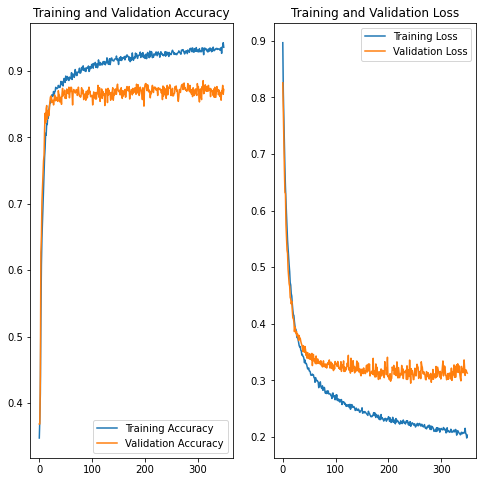

In [11]:
acc = history.history['action_output_accuracy']
val_acc = history.history['val_action_output_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
_ = model.evaluate(x=testX, y={'action_output': testActionY, 'rate_output': testRateY})
# "coll_output": testCollY, "comp_output": testCompY, "pred_output": testPredY, "self_output": testSelfY, "wise_output": testWiseY})

35/35 [==============================] - 0s 1ms/step - loss: 0.3128 - action_output_loss: 0.4188 - rate_output_loss: 0.0824 - action_output_accuracy: 0.8722 - rate_output_accuracy: 0.2350


In [13]:
# Save the entire model as a SavedModel.
model.save('./data/'+map_dir+'/humanModel_v2.h5')

In [14]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [15]:
path = "./data/humanModel_v1_dataset/38/-Ms8av2Z5M2XEIGMqjsx_70.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array / 255.0
predictions = model.predict(img_array)

print(f"The vector rate: {predictions[1]}")
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions[0]), 100 * np.max(predictions[0]))
)

The vector rate: [[0.26612246 0.9318166  0.756619   0.47105235 0.56037027]]
This image most likely belongs to 2 with a 79.41 percent confidence.
